In [1]:
import os, sys
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
print('tensorflow version: ',tf.__version__)

tensorflow version:  2.0.0


In [2]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

### Data processing

<a href link='http://www.manythings.org/anki/'>dataset</a>

In [3]:
with open(r'/Users/user/Desktop/python_stuff/NLP/mar-eng/mar.txt', encoding="utf-8") as file:
    head = [next(file) for x in range(2)]
print(head)

['Go.\tजा.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #3138228 (sabretou)\n', 'Run!\tपळ!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #3138217 (sabretou)\n']


In [7]:
# We limit the sentences to 2500.
# File has English sentence its corrosponding Hindi sentence and its attribute.
# We need to split them by '\t' and create a list of English sentences, its corrosponding Hindi sentences with
# end of sentence <eos> postfix and a third list of same Hindi sentences with start of sentence <sos> prefix

input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open(r'/Users/user/Desktop/python_stuff/NLP/mar-eng/mar.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence, output, attribute = line.rstrip().split('\t')

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 20000
num samples output: 20000
num samples output input: 20000


In [8]:
print('Input sentence: ',input_sentences[250])
print('Output sentence: ',output_sentences[250])
print('Output sentence as input: ',output_sentences_inputs[250])

Input sentence:  Don't ask.
Output sentence:  विचारू नका. <eos>
Output sentence as input:  <sos> विचारू नका.


### Tokenization

In [10]:
# Tokenize the input sentences(English Language)

input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

input_word_index = input_tokenizer.word_index
print('Longest sentence has {} words'.format(max_input_len))

max_input_len = max(len(x) for x in input_integer_seq)
print('Total unique words: ',len(input_word_index))

Longest sentence has 8 words
Total unique words:  3052


In [25]:
# Tokenize the output sentences(Hindi Language)

output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

output_word_index = output_tokenizer.word_index
print('Total unique words are: ', len(output_word_index))

num_words_output = len(output_word_index) + 1
max_out_len = max(len(x) for x in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words are:  7422
Length of longest sentence in the output: 10


###  Padding

<p>We need to pad our inputs and outputs because each inputs and outputs are of different length 
<p>LSTM model expects all the inputs to be of the same size.

In [26]:
# Input padding

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print('padded input sequence shape: ',encoder_input_sequences.shape)
print('padded input sequence example 250: ', encoder_input_sequences[250])


padded input sequence shape:  (20000, 8)
padded input sequence example 250:  [  0   0   0   0   0   0  20 214]


In [27]:
# Output padding

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print('padded output sequence shape: ', decoder_input_sequences.shape)
print('padded output sequence example 250: ', decoder_input_sequences[250])

padded output sequence shape:  (20000, 10)
padded output sequence example 250:  [  2 797  62   0   0   0   0   0   0   0]


In [28]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print(decoder_output_sequences.shape)
decoder_output_sequences[250]

(20000, 10)


array([797,  62,   1,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
"""
In the encoder, zeros were padded at the beginning. 
The reason behind this is that encoder output is based on the words occurring at the end of the sentence, 
therefore the original words were kept at the end of the sentence and zeros were padded at the beginning. 
In the case of the decoder, the post-padding is applied,
which means that zeros are appended at the end of the sentence. 
We do this because in the decoder the processing starts from the beginning of a sentence, 
hence post-padding is performed in the decoder.
"""

### Word Embeddings

<p>For the English sentences, i.e. the inputs, we will use the GloVe word embeddings. For the translated Hindi sentences in the output, we will use custom word embeddings.

In [29]:
# reate a dictionary where words are the keys and the corresponding vectors are values

import numpy as np

embeddings_dictionary = dict()
glove_file = open(r"/Users/user/Desktop/python_stuff/NLP/glove.6B/glove.6B.100d.txt", encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [30]:
num_words = min(MAX_NUM_WORDS, len(input_word_index)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_SIZE))
for word, index in input_word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        


In [31]:
embeddings_dictionary['ask']

array([-0.1683   , -0.0019777,  0.58425  ,  0.049124 , -0.71453  ,
        0.54004  , -0.97538  ,  0.5354   ,  0.33698  , -0.53466  ,
       -0.034012 , -0.2097   ,  0.12526  , -0.1041   , -0.2868   ,
       -0.32599  , -0.16661  ,  0.28927  , -1.233    ,  0.82418  ,
       -0.39825  , -0.22972  , -0.59276  , -0.53729  , -0.18147  ,
        0.12286  , -0.15221  , -0.83222  ,  0.89938  , -0.11236  ,
        0.032309 ,  0.66448  ,  0.1633   ,  0.15404  , -0.10801  ,
        0.83764  , -0.060524 , -0.3577   ,  0.61084  , -0.44643  ,
       -0.49839  ,  0.10557  ,  0.056381 , -1.0175   , -0.72203  ,
       -0.13838  , -0.44938  , -0.33304  , -0.26042  , -0.96384  ,
        0.29383  ,  0.2488   ,  0.22366  ,  0.42337  , -0.43409  ,
       -1.2643   ,  0.12757  , -0.068352 ,  1.5724   ,  0.086132 ,
       -0.038491 ,  0.43654  , -0.16079  , -0.27936  ,  0.90421  ,
        0.077429 ,  0.16837  ,  1.256    , -0.29884  , -0.14675  ,
        0.0060162,  0.0045875, -0.26939  , -0.94483  ,  0.1784

In [32]:
embedding_matrix[214]

array([-0.1683    , -0.0019777 ,  0.58424997,  0.049124  , -0.71452999,
        0.54004002, -0.97538   ,  0.53539997,  0.33697999, -0.53465998,
       -0.034012  , -0.2097    ,  0.12526   , -0.1041    , -0.2868    ,
       -0.32598999, -0.16661   ,  0.28927001, -1.23300004,  0.82418001,
       -0.39825001, -0.22972   , -0.59276003, -0.53728998, -0.18147001,
        0.12286   , -0.15221   , -0.83222002,  0.89938003, -0.11236   ,
        0.032309  ,  0.66447997,  0.16329999,  0.15403999, -0.10801   ,
        0.83763999, -0.060524  , -0.35769999,  0.61084002, -0.44643   ,
       -0.49838999,  0.10557   ,  0.056381  , -1.01750004, -0.72202998,
       -0.13838001, -0.44938001, -0.33304   , -0.26041999, -0.96384001,
        0.29383001,  0.24879999,  0.22366001,  0.42337   , -0.43408999,
       -1.26429999,  0.12757   , -0.068352  ,  1.57239997,  0.086132  ,
       -0.038491  ,  0.43654001, -0.16079   , -0.27936   ,  0.90420997,
        0.077429  ,  0.16836999,  1.25600004, -0.29883999, -0.14

### Creating the model

In [33]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [34]:
decoder_targets_one_hot = np.zeros((len(input_sentences),
                                    max_out_len,
                                    num_words_output),
                                    dtype='float32')

In [35]:
decoder_targets_one_hot.shape

(20000, 10, 7423)

<p>the final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors, since we will be using softmax activation function at the dense layer.

In [36]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

### Define the encoder

In [37]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

### Define decoder

In [38]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

<p>output from the decoder LSTM is passed through a dense layer to predict decoder outputs

In [39]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

### Compile the model

In [40]:
model = Model([encoder_inputs_placeholder,
               decoder_inputs_placeholder],
               decoder_outputs)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Plot the model

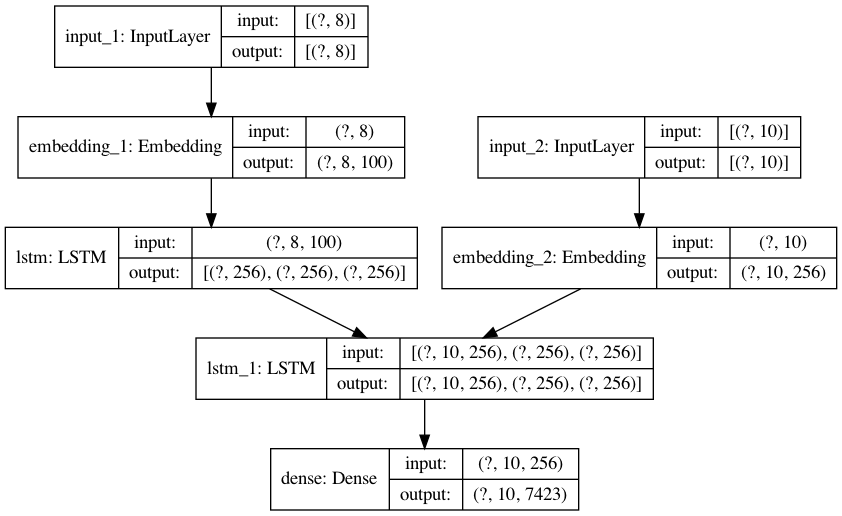

In [41]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [42]:
r = model.fit([encoder_input_sequences, decoder_input_sequences],
              decoder_targets_one_hot,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_split=0.1,)

Train on 18000 samples, validate on 2000 samples
Epoch 1/20
18000/18000 [==============================] - 145s 8ms/sample - loss: 2.5869 - accuracy: 0.6366 - val_loss: 2.8740 - val_accuracy: 0.6055
Epoch 2/20
18000/18000 [==============================] - 159s 9ms/sample - loss: 1.9684 - accuracy: 0.7018 - val_loss: 2.5297 - val_accuracy: 0.6378
Epoch 3/20
18000/18000 [==============================] - 141s 8ms/sample - loss: 1.6716 - accuracy: 0.7384 - val_loss: 2.3114 - val_accuracy: 0.6615
Epoch 4/20
18000/18000 [==============================] - 153s 8ms/sample - loss: 1.4656 - accuracy: 0.7628 - val_loss: 2.1919 - val_accuracy: 0.6762
Epoch 5/20
18000/18000 [==============================] - 4266s 237ms/sample - loss: 1.3090 - accuracy: 0.7841 - val_loss: 2.0896 - val_accuracy: 0.6896
Epoch 6/20
18000/18000 [==============================] - 149s 8ms/sample - loss: 1.1819 - accuracy: 0.8021 - val_loss: 2.0307 - val_accuracy: 0.6980
Epoch 7/20
18000/18000 [========================

### Fine tuning

In [43]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# At each time step, there will be only a single word in the decoder input
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# We need to create the placeholder for decoder outputs
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

# To make predictions, the decoder output is passed through the dense layer
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

# Define the updated decoder model
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

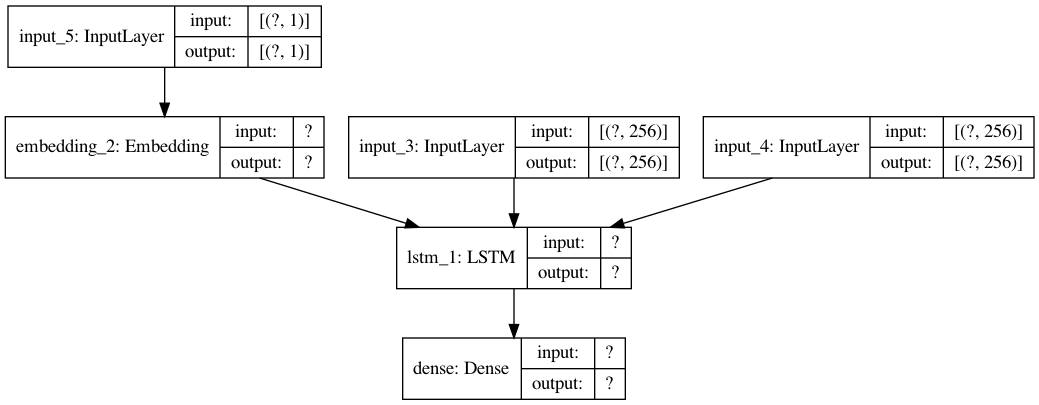

In [44]:
from tensorflow.keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

### Making predictions

In [45]:
idx2word_input = {v:k for k, v in input_word_index.items()}
idx2word_target = {v:k for k, v in output_word_index.items()}

<p>we will create a method, i.e. translate_sentence(). The method will accept an input-padded sequence English sentence (in the integer form) and will return the translated Hindi sentence

In [46]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = output_word_index['<sos>']
    eos = output_word_index['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [52]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: Tell me the story.
Response: मला गोष्ट सांगा.
